# Assignment #1

## Overview of our assignment
* Given a face image dataset, namely CelebA, you need to perform classification on it, using MLP and multiple CNN architectures, and then report the results.
* We provide three models for classification, such as MLP, VGG, and ResNet-18, which can be used as the base architectures for your assignment.
* You should implement the following three regularization techniques: 1) Dropout, 2) L2 normalization, and 3) L1 normalization, based upon the provided three models, and then report the results. 
* Also, you should implement the following three optimization methods: 1) SGD with Momentum, 2) AdaGrad, and 3) Adam, and then report the obtained results as well.

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt
from PIL import Image

## Preparing the CelebA dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

Download link: https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg

1) Download and unzip the file `./Img/img_align_celeba.zip`, which contains the images in jpeg format.

2) Download the `./Anno/list_attr_celeba.txt` file, which contains the class labels.

3) Download the `./Eval/list_eval_partition.txt` file, which contains  training/validation/test partitioning info.

Please make sure that, all your downloaded files (or unzipped folders) are located inside of the "./data" folder to run below codes.

For example,
* ./data/list_attr_celeba.txt
* ./data/list_eval_partition.txt
* ./data/img_align_celeba/{IMAGE_NAME}.jpg

(218, 178, 3)


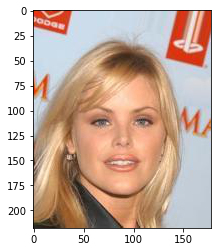

In [2]:
# Print sample image
img = Image.open('./data/img_align_celeba/img_align_celeba/000029.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

## Implementing the DataLoader for training, validation, and test

In [3]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [4]:
custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((32, 32)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

In [5]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

# custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
#                                        transforms.Resize((32, 32)),
#                                        #transforms.Grayscale(),                                       
#                                        #transforms.Lambda(lambda x: x/255.),
#                                        transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='./data/celeba-gender-train.csv',
                              img_dir='./data/img_align_celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='./data/celeba-gender-valid.csv',
                              img_dir='./data/img_align_celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='./data/celeba-gender-test.csv',
                             img_dir='./data/img_align_celeba/img_align_celeba/',
                             transform=custom_transform)

BATCH_SIZE=256


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=12)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=12)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=12)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(0)

cuda:0


In [7]:
# Testing dataloader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 256


In [8]:
x.shape

torch.Size([256, 3, 32, 32])

## Implementing models

In [13]:
# Hyperparameters
random_seed = 42
learning_rate = 0.001
num_epochs = 10

# Architecture
num_features = 32*32
num_classes = 2

In [14]:
from models import mlp
from models import vgg
from models import resnet

## Define Base Model Function

In [15]:
def base_model_function(model, optimizer, num_epoch):
    start_time = time.time()
    
    num_epochs = num_epoch
    for epoch in range(num_epochs):
        # print(epoch)
        running_loss, val_running_loss = 0.0, 0.0
        running_corrects, val_running_corrects = 0.0, 0.0
        num_examples = 0

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            _, predicted_labels = torch.max(probas, 1)
            cost = F.cross_entropy(logits, targets)
            optimizer.zero_grad()

            cost.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ## loss 더해주기
            running_loss += cost.item()

            ## correct 더해주기
            num_examples += targets.size(0)
            running_corrects += (predicted_labels == targets).sum()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, num_epochs, batch_idx, 
                         len(train_loader), cost))

        # epoch loss 계산
        ## print(running_loss)
        ## print(len(train_loader))
        epoch_loss = running_loss/len(train_loader)
        running_loss_history.append(epoch_loss)

        # epoch accuracy 계산
        ## print(running_corrects)
        ## print(num_examples)
        epoch_acc = running_corrects/num_examples * 100
        running_corrects_history.append(epoch_acc)

        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            correct_pred, num_examples = 0, 0
            for i, (features, targets) in enumerate(valid_loader):

                features = features.to(device)
                targets = targets.to(device)

                logits, probas = model(features)
                _, predicted_labels = torch.max(probas, 1)
                cost = F.cross_entropy(logits, targets)

                val_running_loss += cost.item()
                num_examples += targets.size(0)
                val_running_corrects += (predicted_labels == targets).sum()

            # epoch loss 계산
            val_epoch_loss = val_running_loss/len(valid_loader)
            val_running_loss_history.append(val_epoch_loss)

            # epoch accuracy 계산
            val_epoch_acc = val_running_corrects/num_examples * 100
            val_running_corrects_history.append(val_epoch_acc)

            print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
                  epoch+1, num_epochs, 
                  epoch_acc,
                  val_epoch_acc))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

## Training

In [16]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        # cost = F.cross_entropy(logits, targets)
        
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
#     print('num_examples :', num_examples)
#     print('correct_pred :', correct_pred)
    return correct_pred.float()/num_examples * 100

## Compare Optimization Methods

## 1. MLP Basic - without any Opimization method

In [17]:
model = mlp.MLP()                 # For MLP
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [20]:
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.7071
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.7018
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.6986
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.6955
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.6958
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.6947
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.6932
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.6921
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.6899
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.6894
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.6875
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.6914
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.6842
Epoch: 001/010 | Train: 50.746% | Valid: 57.427%
Time elapsed: 0.66 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.6831
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.6846
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.6869
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.6843
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.6819
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.6866
Epoch: 002/010 |

### Evaluation

In [21]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 61.35%


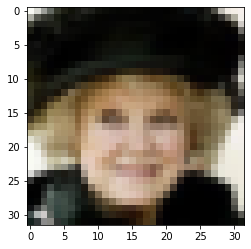

In [22]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [23]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 56.77%


### Visualization

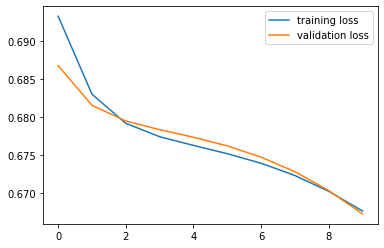

In [24]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [25]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

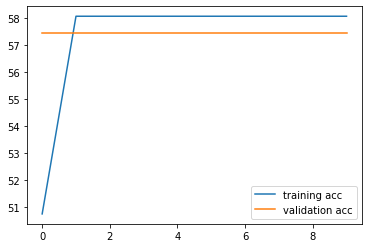

In [26]:
plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## 2. MLP with SGD w/momentum

In [27]:
model = mlp.MLP()                 # For MLP
model = model.to(device)

In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)

In [29]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [30]:
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.6972
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.6836
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.6817
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.6762
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.6806
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.6896
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.6771
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.6703
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.6733
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.6747
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.6648
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.6757
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.6711
Epoch: 001/010 | Train: 57.562% | Valid: 57.427%
Time elapsed: 0.85 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.6549
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.6630
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.6672
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.6467
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.6579
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.6392
Epoch: 002/010 |

### Evaluation

In [31]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 94.06%


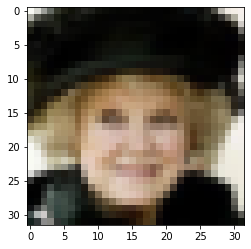

In [32]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [33]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 96.74%


### Visualization

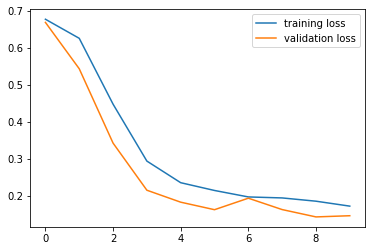

In [34]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

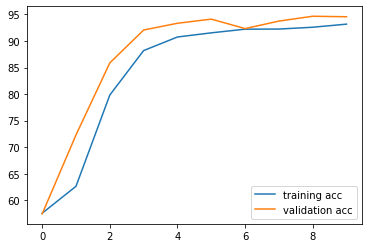

In [35]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## 3. MLP with Adagrad

In [36]:
model = mlp.MLP()                 # For MLP
model = model.to(device)

optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

In [37]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [38]:
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.6999
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.6512
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.5739
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.4992
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.5279
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.4330
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.4698
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.3704
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.3843
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.3999
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.4389
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.3364
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.3546
Epoch: 001/010 | Train: 76.886% | Valid: 82.066%
Time elapsed: 0.54 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.4019
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.3829
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.3269
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.4546
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.3593
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.3522
Epoch: 002/010 |

### Evaluation

In [39]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 92.54%


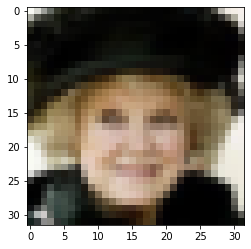

In [40]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [41]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 91.10%


### Visualization

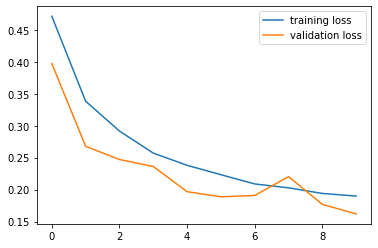

In [42]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

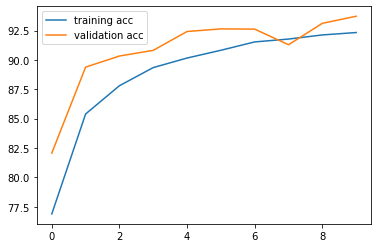

In [43]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()

## 4. MLP with Adam

In [51]:
model = mlp.MLP()                 # For MLP
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [53]:
base_model_function(model, optimizer, num_epochs)

Epoch: 001/010 | Batch 0000/0636 | Cost: 0.6888
Epoch: 001/010 | Batch 0050/0636 | Cost: 0.5644
Epoch: 001/010 | Batch 0100/0636 | Cost: 0.4293
Epoch: 001/010 | Batch 0150/0636 | Cost: 0.3844
Epoch: 001/010 | Batch 0200/0636 | Cost: 0.4291
Epoch: 001/010 | Batch 0250/0636 | Cost: 0.3492
Epoch: 001/010 | Batch 0300/0636 | Cost: 0.2828
Epoch: 001/010 | Batch 0350/0636 | Cost: 0.3799
Epoch: 001/010 | Batch 0400/0636 | Cost: 0.2472
Epoch: 001/010 | Batch 0450/0636 | Cost: 0.1950
Epoch: 001/010 | Batch 0500/0636 | Cost: 0.2517
Epoch: 001/010 | Batch 0550/0636 | Cost: 0.2658
Epoch: 001/010 | Batch 0600/0636 | Cost: 0.2212
Epoch: 001/010 | Train: 83.728% | Valid: 91.569%
Time elapsed: 0.37 min
Epoch: 002/010 | Batch 0000/0636 | Cost: 0.2385
Epoch: 002/010 | Batch 0050/0636 | Cost: 0.3309
Epoch: 002/010 | Batch 0100/0636 | Cost: 0.2387
Epoch: 002/010 | Batch 0150/0636 | Cost: 0.3572
Epoch: 002/010 | Batch 0200/0636 | Cost: 0.2339
Epoch: 002/010 | Batch 0250/0636 | Cost: 0.1907
Epoch: 002/010 |

### Evaluation

In [54]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 93.99%


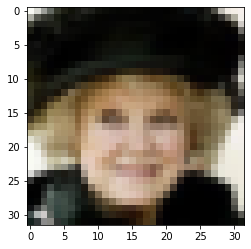

In [55]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [56]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Female %.2f%%' % (probas[0][0]*100))

Probability Female 89.15%


### Visualization

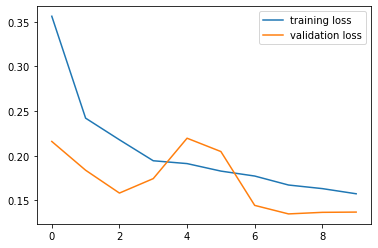

In [57]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

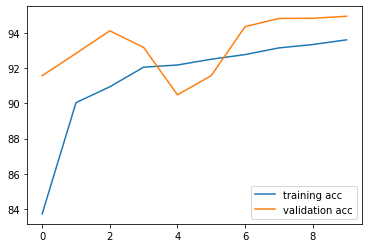

In [58]:
np_running_corrects_history = []
np_val_running_corrects_history = []

for t, v_t in zip(running_corrects_history, val_running_corrects_history):
    acc = t.cpu().numpy().max() 
    val_acc = v_t.cpu().numpy().max() 
    
    np_running_corrects_history.append(acc)
    np_val_running_corrects_history.append(val_acc)

plt.plot(np_running_corrects_history, label='training acc')
plt.plot(np_val_running_corrects_history, label='validation acc')
plt.legend()